In [235]:
import os
import sys

import pandas as pd
import numpy as np

from sklearn.preprocessing import normalize, scale
from sklearn.decomposition import PCA
from collections import OrderedDict

from synchromesh.scripts.utils import read_str_list, sanitize_mtx, norm, do_pf, do_log_pf
from synchromesh.scripts.plot import  plot_depth_norm, plot_depth_dist, plot_knee, plot_pc_depth, plot_mean_var, plot_monotone, plot_example_gene

from scipy.sparse import csr_matrix
from scipy.io import mmread, mmwrite
from scipy import stats


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=15


alpha = 0.33

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["font.size"] = fsize
%config InlineBackend.figure_format = 'retina'

In [16]:
def get_min_diff(matrix):
    x = matrix.flatten()
    xs = np.sort(x)
    b = xs[0]
    mn = 1100.
    for i in range(1, xs.shape[0]):
        a = xs[i]
        if a == b:
            continue

        diff = abs(a-b)
        if diff < mn and diff > 0:
            mn = diff
        b = a
    return mn

def mono(matrix, raw):
    rv = np.zeros(matrix.shape[0])
    for i in range(matrix.shape[0]):
        r, p  = stats.spearmanr(matrix[i], raw[i])
        rv[i] = r
    return rv

def plot_meanvar(mtx, raw_mean, minlim = 1e-4, maxlim = 1e5, ax=None):
    p = {
        "xlabel": "Gene mean",
        "ylabel": "Gene variance",
        "xscale": "log",
        "yscale": "log",
        "xlim": (minlim, maxlim),
    }

    y = np.var(mtx, axis=0)
    yy = (y-y.mean())/np.sqrt(np.var(y))

    ax.scatter(raw_mean, y, facecolor="#D43F3A", alpha=alpha, edgecolor="k")
    ax.axhline(1, color="k", linestyle="--")
    ax.set(**p)
    yex(ax)
    return ax

def plot_depth(mtx, raw_cell_counts, ax):
    x = np.sum(mtx, axis=1)

    mean = x.mean()
    stdev = np.sqrt(np.var(raw_cell_counts))

    close = np.all(np.allclose(x, x[0]))

    if close:
        weights=np.ones(len(x)) / len(x)
        ax.hist([0] * len(x), facecolor="#D43F3A", weights=weights, edgecolor="k")
    else:
        weights=np.ones(len(x)) / len(x)
        xx = (x - mean)/stdev
        ax.hist(xx, facecolor="#D43F3A", weights=weights, edgecolor="k")
    p = {
      "xlabel": "Z-score (cell counts)",
      "ylabel": "Frequency",
    }
    p.update({ "xlim": (- 3, 3)})
    ax.set(**p)
    return ax

def plot_mono(matrix, raw, ax):
    x = mono(matrix, raw)
    p = {
        "xlabel": "Spearman r",
        "ylabel": "Frequency",
        "xlim": (-0.1, 1.2)
    }
    close = np.all(np.allclose(x, x[0]))
    if close:
        weights=np.ones(len(x)) / len(x)
        ax.hist([1] * len(x), facecolor="#D43F3A", edgecolor="k", weights=weights)
    else:
        weights=np.ones(len(x)) / len(x)
        ax.hist(x, facecolor="#D43F3A", weights=weights, edgecolor="k")
    ax.set(**p)
    return ax

In [152]:
read_labels = ['raw', 'pf', 'log', 'pf_log', 'pf_log_pf', 'cpm_log', 'cp10k_log', "sqrt"]
labels = ['raw', 'pf', "sqrt", 'log', 'cp10k_log', 'cpm_log', 'cp10k_log_scale', 'sctransform', 'pf_log', 'pf_log_pf']

In [10]:
def read_data(base_data_fn):
    data = {}

    for title in read_labels:
        print(f"loading {title}")
        in_fn = os.path.join(base_data_fn, f"_{title}.mtx")
        data[title] = mmread(in_fn).toarray()

    title = "sctransform"
    print(f"loading {title}")
    in_fn = os.path.join(base_data_fn, f"_{title}.csv")
    data[title] = pd.read_csv(in_fn, header=None).values

    title = "cp10k_log_scale"
    print(f"loading {title}")
    in_fn = os.path.join(base_data_fn, f"_{title}.csv")
    data[title] = pd.read_csv(in_fn, header=None).values
    return data

In [11]:
ds = "angelidis_2019"
out_prefix =  os.path.join("synchromesh/data/", ds)

In [12]:
%%time
data = read_data(out_prefix)

loading raw
loading pf
loading log
loading pf_log
loading pf_log_pf
loading cpm_log
loading cp10k_log
loading sqrt
loading sctransform
loading cp10k_log_scale
CPU times: user 10min 57s, sys: 31.3 s, total: 11min 29s
Wall time: 11min 30s


In [20]:
bcs = pd.read_csv(os.path.join(out_prefix, "barcodes.csv"), index_col=0)
assignments = bcs.celltype.values
    
genes = []
read_str_list(os.path.join(out_prefix, "_genes.txt"), genes)
genes = np.array(genes)

# Comparison

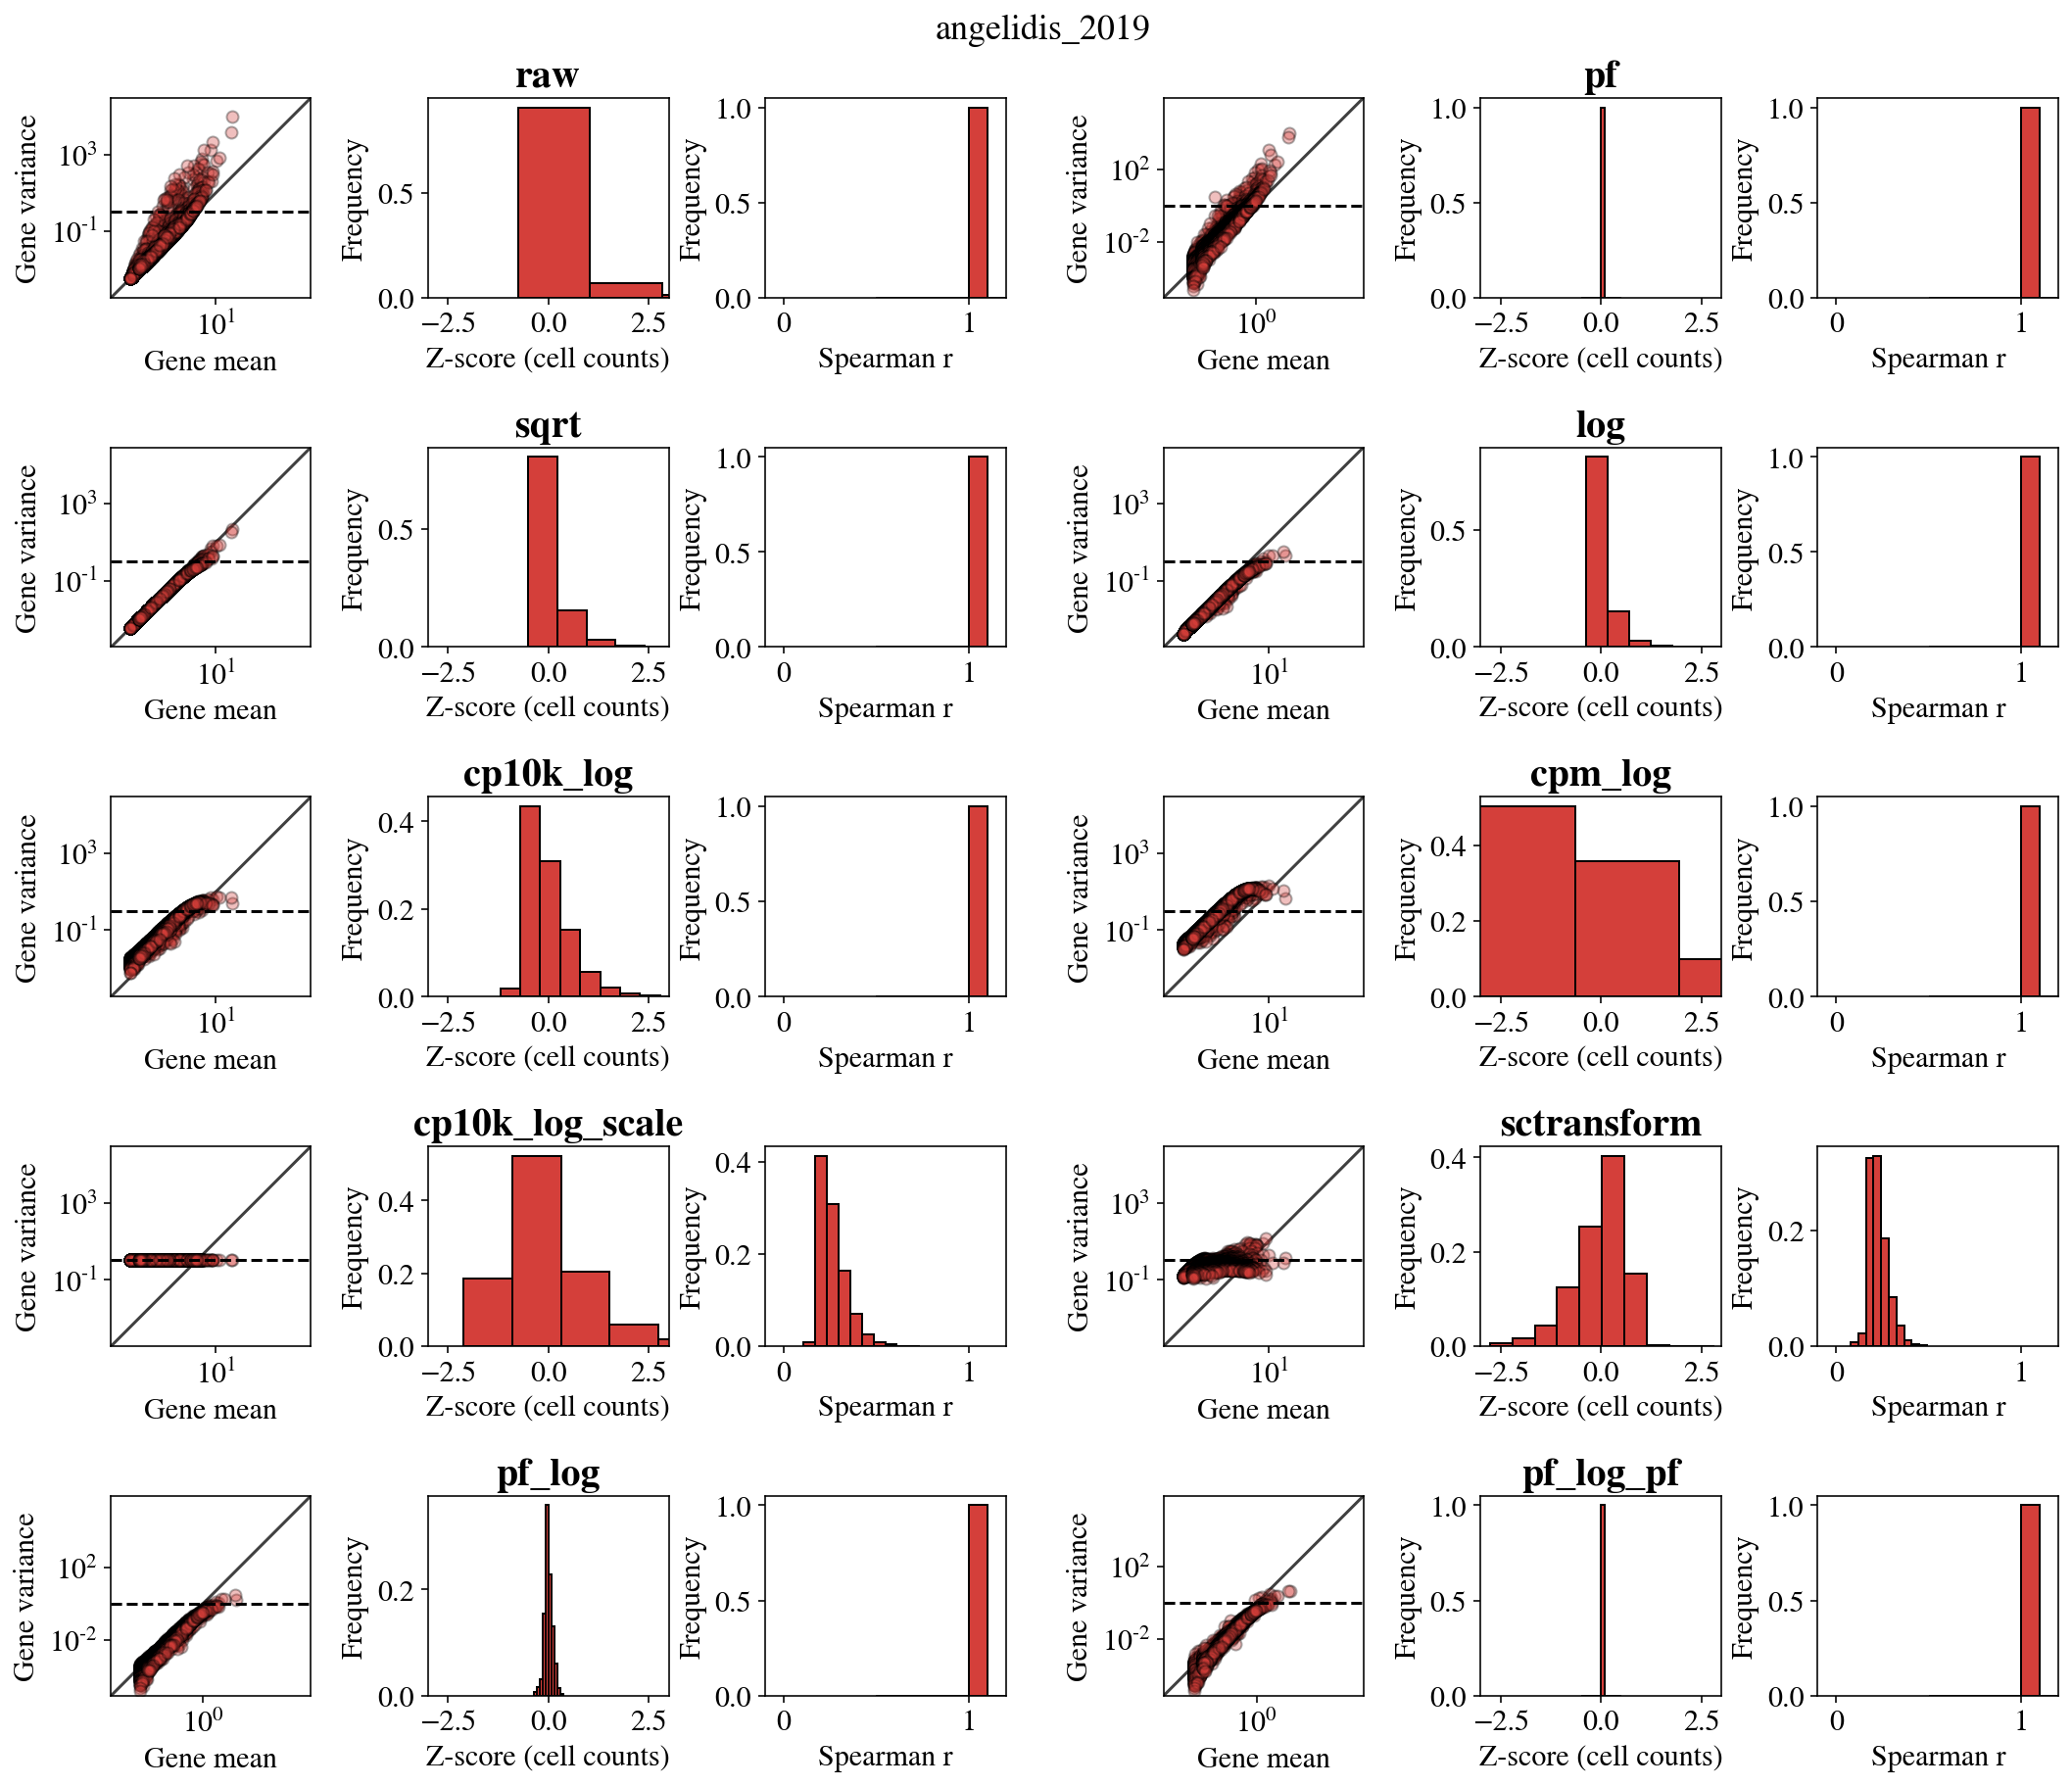

In [153]:
fig = plt.figure(figsize=(6*3,5*3))
fig.suptitle(ds, y=0.92)
gs = gridspec.GridSpec(5, 2, figure=fig, wspace=0.15, hspace=0.75)
axs = []
for i in range(5):
    for j in range(2):
        ig = gs[i,j].subgridspec(1, 3, wspace=0.4)
        ax1 = fig.add_subplot(ig[0, 0])
        ax2 = fig.add_subplot(ig[0, 1])
        ax3 = fig.add_subplot(ig[0, 2])
        axs.append((ax1, ax2, ax3))

raw = data["raw"]

minlim = min(np.min(np.var(raw, 0)), np.min(np.mean(raw, 0))) * 0.1
maxlim = max(np.max(np.var(raw, 0)), np.max(np.mean(raw, 0))) * 10
for (ax1, ax2, ax3), title in zip(axs, labels):
    m = data[title]
    plot_meanvar(m, raw.mean(0), minlim = minlim, maxlim = maxlim, ax=ax1)
    plot_depth(m, raw.sum(1), ax2)
    plot_mono(m, raw, ax3)
    ax2.set_title(title, fontsize=20, weight="bold")

# fig.savefig(f"{ds}.png", facecolor='white', transparent=False, dpi=200, bbox_inches="tight")
fig.show()

In [14]:
metrics = {}
for k, m in data.items():
    gvar = np.var(m, axis=0)
    gmean = np.mean(m, axis=0)
    cellmean = np.mean(m, axis=1)
    
    cutoff = 0.2
    
    metrics[k] = {
        "cov_gene_var": np.sqrt(np.var(gvar))/np.mean(gvar),
        "cov_gene_var_mean_upper": np.sqrt(np.var(gvar[gmean >= cutoff]))/np.mean(gvar[gmean >= cutoff]),
        "cov_gene_var_mean_lower": np.sqrt(np.var(gvar[gmean < cutoff]))/np.mean(gvar[gmean < cutoff]),
        "cov_cell_depth": np.sqrt(np.var(cellmean)) / np.abs(np.mean(cellmean)),
    }
[(i, metrics[i]["cov_cell_depth"]) for i in metrics.keys()]

[('raw', 0.990769672107577),
 ('pf', 1.978100487734057e-16),
 ('log', 0.727664667126467),
 ('pf_log', 0.21649862064400838),
 ('pf_log_pf', 1.8836920083722822e-16),
 ('cpm_log', 0.523226607648556),
 ('cp10k_log', 0.3632458593080609),
 ('sqrt', 0.7166784470547205),
 ('sctransform', 0.4859820065727331),
 ('cp10k_log_scale', 1988917721405344.0)]

# Celltype spearman

In [18]:
def pairwise_spearman(X, mn=0):
    mns = np.random.uniform(-mn/4, mn/4, size=X.shape[1])
    X = X.astype(float) + mns
    corr = stats.spearmanr(X, axis=1).correlation
    corr = corr[np.triu_indices(corr.shape[0], k=1)]
    return corr

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

In [299]:
pd.DataFrame({"cellsum": data["raw"].sum(1), "celltype":assignments}).groupby("celltype").agg({"cellsum": ["var", "count", "sum", "mean"]})["cellsum"].sort_values(["count"], ascending=False)

,var,count,sum,mean
celltype,,,,
Type_2_pneumocytes,3.808068e+05,4199,3717832,885.408907
Alveolar_macrophage,2.463729e+05,1704,1185836,695.913146
Ciliated_cells,1.227495e+06,883,887542,1005.143828
B_cells,2.415417e+05,855,496537,580.745029
Club_cells,2.957619e+06,772,1221242,1581.919689
vascular_endothelial_cells,5.747923e+04,631,279089,442.296355
CD8+_T_cells,2.166643e+05,612,389606,636.611111
Cd4+_T_cells,1.352873e+05,591,336177,568.827411
low_quality_cells,3.294878e+04,495,214193,432.713131


In [22]:
%%time
mins = {}
for l in labels:
    mins[l] = get_min_diff(data[l])
mins

CPU times: user 7min 24s, sys: 11.6 s, total: 7min 35s
Wall time: 7min 35s


{'raw': 1,
 'pf': 5.551115123125783e-17,
 'log': 0.0003156067566045806,
 'pf_log': 1.1102230246251565e-16,
 'pf_log_pf': 1.1102230246251565e-15,
 'cpm_log': 6.108287102790655e-07,
 'cp10k_log': 6.107294758805892e-07,
 'cp10k_log_scale': 5.992983886926595e-13,
 'sctransform': 6.938893903907228e-16,
 'sqrt': 0.008884064315125784}

In [23]:
celltype = "Alveolar_macrophage"
ctype_mask = assignments == celltype

## Pairwise

In [155]:
l = data["raw"][ctype_mask].sum(0)
downsample_genes = l > 0
sp = {}
for l in labels:
    print(l)
    mtx = data[l]
    X = mtx[ctype_mask][:,downsample_genes]
    sp[l] = pairwise_spearman(X, mn=mins[l])


raw
pf
sqrt
log
cp10k_log
cpm_log
cp10k_log_scale
sctransform
pf_log
pf_log_pf


In [ ]:
# todo, top 3 cell types, each method has three plots

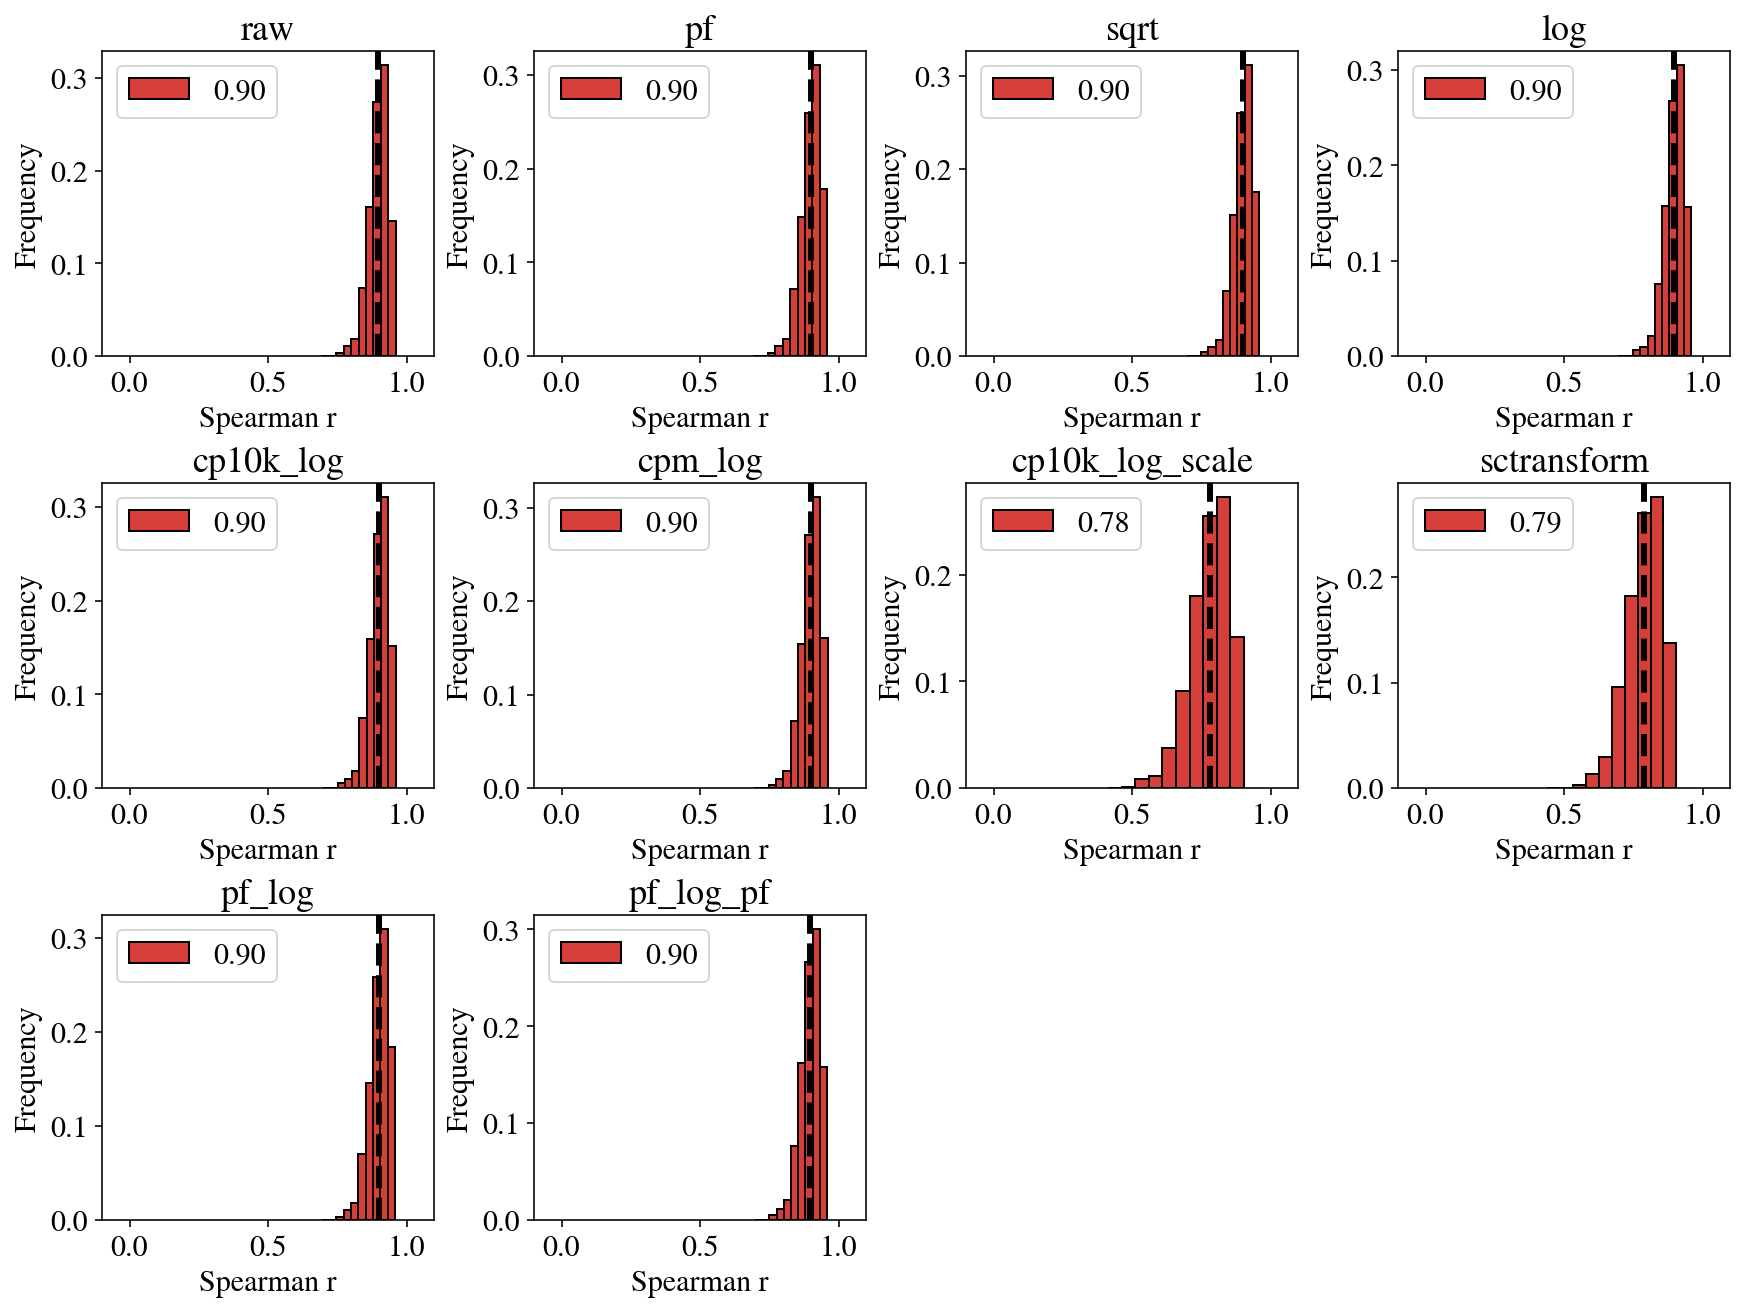

In [156]:
n = len(data.keys())

nr = 3
nc = 4

fig, axs = plt.subplots(figsize=(3*nc,3*nr), ncols=nc, nrows=nr, constrained_layout=True)
axs = trim_axs(axs, n)

p = {
    "xlabel": "Spearman r",
    "ylabel": "Frequency",
    "xlim": (-0.1, 1.1)
}

for idx, l in enumerate(labels):
    ax = axs[idx]
    x = sp[l]
    weights=np.ones(len(x)) / len(x)
    ax.hist(x, weights=weights, facecolor="#D43F3A", edgecolor="k", label=f"{x.mean():,.2f}")
    ax.axvline(x.mean(), color="k", linestyle="--", linewidth=3)
    p.update({"title": l})
    ax.set(**p)
    ax.legend()
    if idx == 0:
        ax.set_ylabel("Frequency")
fig.show()

## cp10k_log_scale v sctransform

In [26]:
def corr2_coeff(A, B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))

In [27]:
corr = np.diagonal(corr2_coeff(data["cp10k_log_scale"][ctype_mask], data["sctransform"][ctype_mask]))

In [158]:
stats.spearmanr(data["cp10k_log_scale"][ctype_mask][0], data["sctransform"][ctype_mask][0])

SpearmanrResult(correlation=0.9819438706033627, pvalue=0.0)

In [ ]:
# todo, do both spearman and pearson

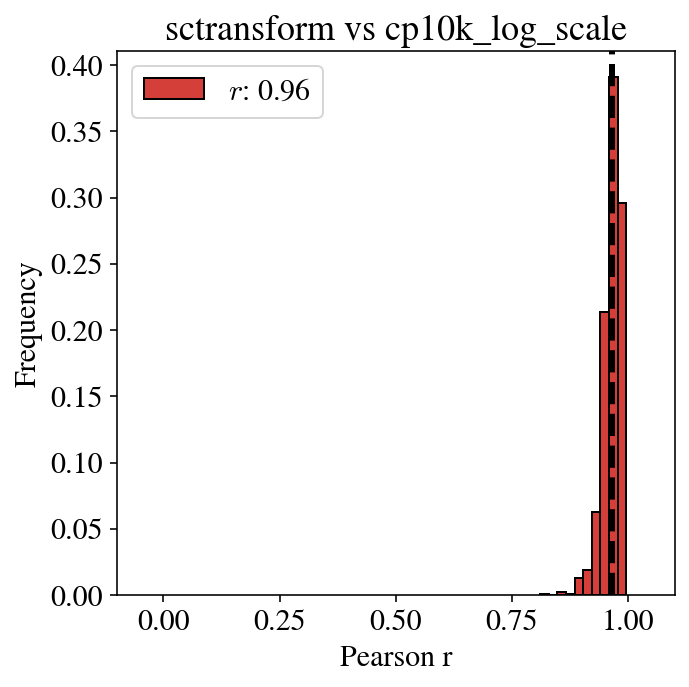

In [28]:
fig, ax = plt.subplots(figsize=(5,5))

x = corr
weights=np.ones(len(x)) / len(x)
ax.hist(x, weights=weights, facecolor="#D43F3A", edgecolor="k", label=f"$r$: {x.mean():,.2f}")
ax.axvline(x.mean(), color="k", linestyle="--", linewidth=3)
ax.legend()

ax.set(**{
    "xlabel": "Pearson r",
    "ylabel": "Frequency",
    "title": "sctransform vs cp10k_log_scale",
    "xlim": (-0.1, 1.1)
})

fig.show()

# PC variance

In [129]:
data["raw"].shape

(14813, 16541)

In [ ]:
%%time
# ## data for pc
pcs = {}
for title, matrix in data.items():
    print(title)
    pca = PCA(n_components=1, svd_solver='full')
    Y = pca.fit_transform(matrix)[ctype_mask]
    pcs[title] = pca.components_

raw
pf
log


In [32]:
ld = np.zeros((len(labels), data["raw"].shape[1]))
for idx, (_, p) in enumerate(pcs.items()):
    ld[idx] = p[0]

In [33]:
ld

array([[-5.75378505e-04, -1.08592950e-03, -7.61835976e-04, ...,
        -7.62273124e-07,  6.52935704e-06,  5.08951529e-06],
       [-9.82355305e-03, -4.08440838e-03, -2.91009005e-03, ...,
        -2.66555326e-07,  2.72570297e-06,  2.76095142e-06],
       [ 2.49210098e-02, -1.68715703e-03, -2.78457393e-03, ...,
         1.18949589e-04,  3.20990469e-04,  3.89226081e-04],
       ...,
       [ 1.21110586e-02, -4.50833045e-03, -3.85971487e-03, ...,
        -2.84902536e-05,  2.37983070e-04,  2.12323930e-04],
       [ 7.98890423e-02,  6.85754150e-02,  6.83727114e-02, ...,
        -7.06622083e-04,  9.19682947e-04,  1.41043594e-03],
       [ 7.63723471e-03, -1.45722600e-04, -5.87274872e-04, ...,
        -1.11064632e-03,  4.83353695e-03,  1.26798010e-02]])

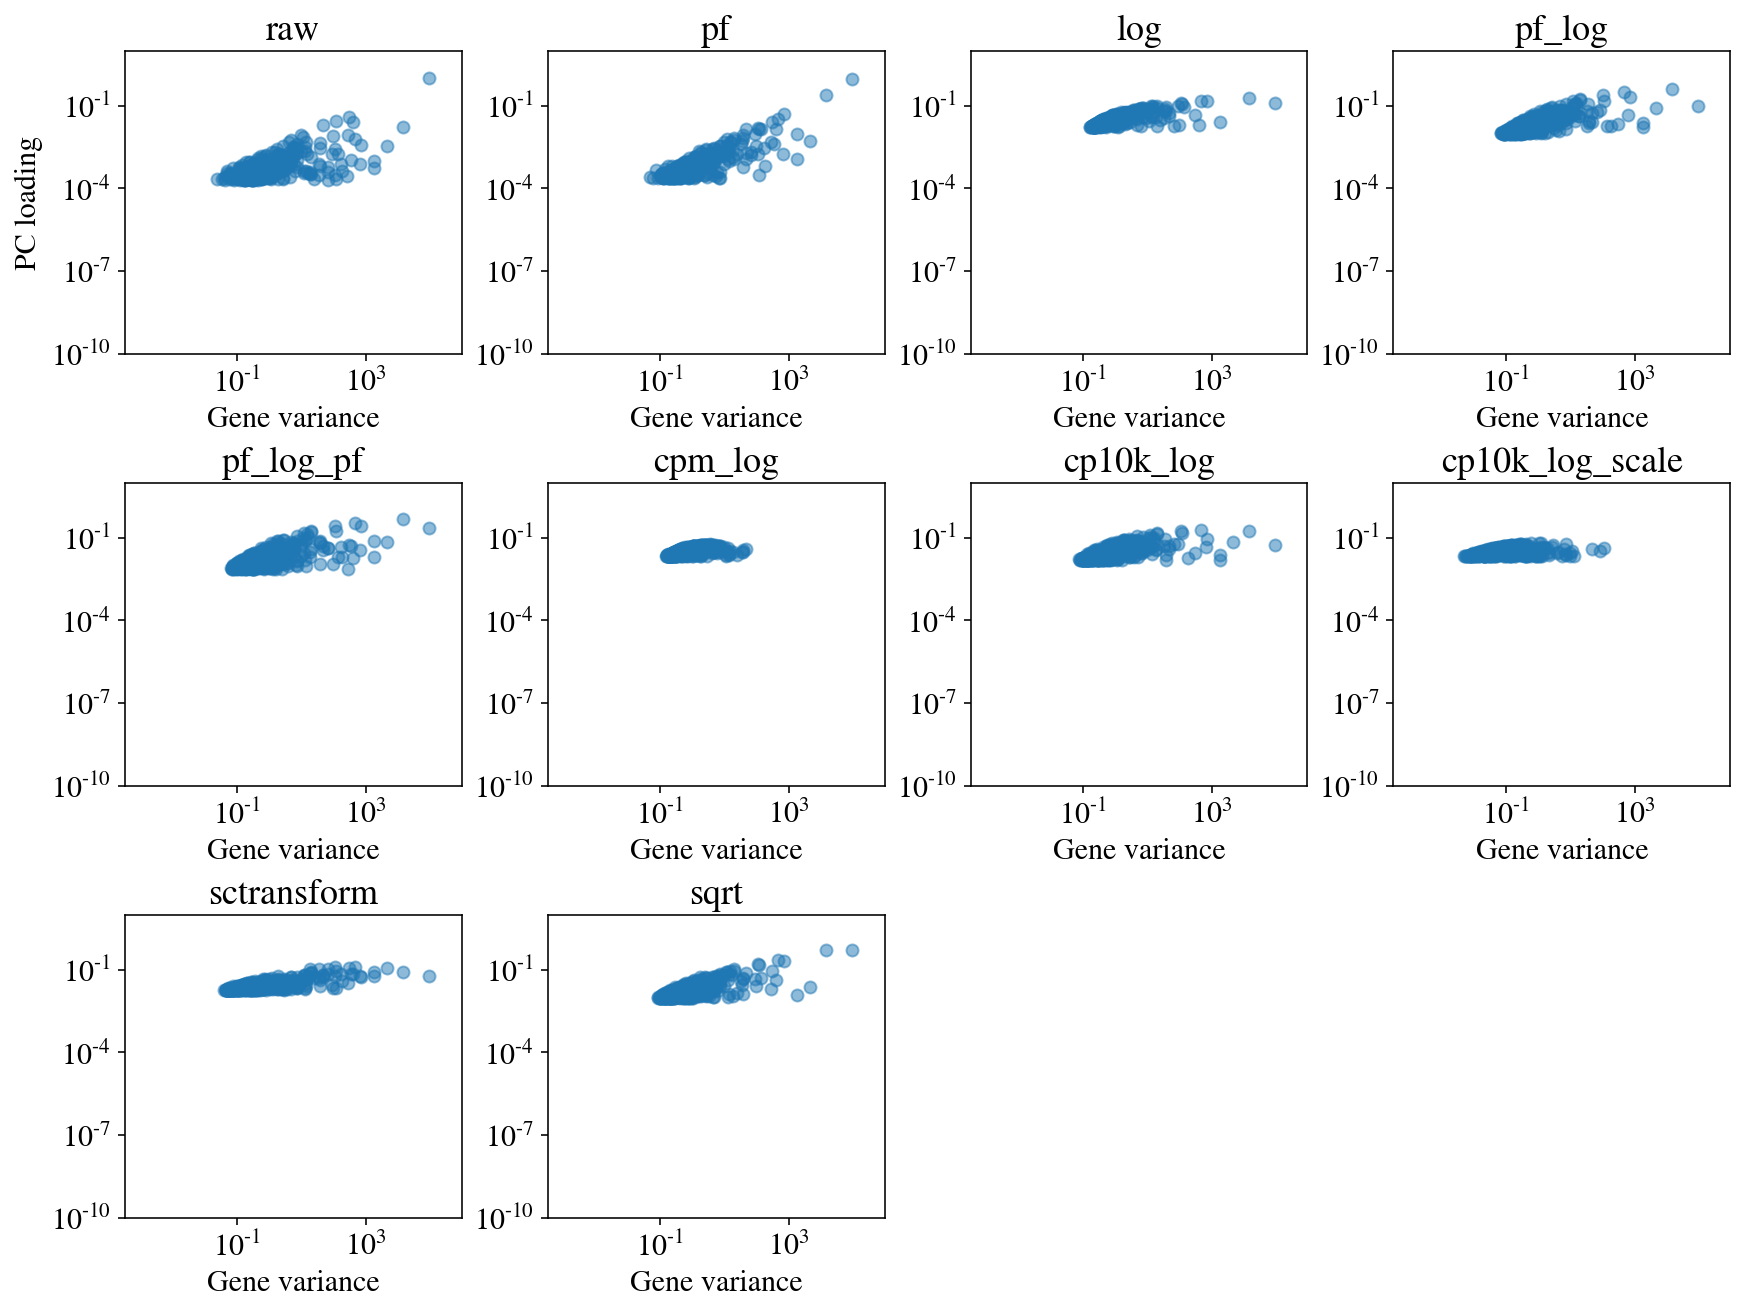

In [81]:
n = len(data.keys())

nr = 3
nc = 4

fig, axs = plt.subplots(figsize=(3*nc,3*nr), ncols=nc, nrows=nr, constrained_layout=True)
axs = trim_axs(axs, n)

x = np.var(data["raw"], 0)

xmn = np.min(x)*.1
xmx = np.max(x)*10

ymn = np.min([np.min(np.abs(v)) for k,v in pcs.items()])
ymx = np.max([np.max(np.abs(v)) for k,v in pcs.items()])*10

p = {
    "xscale": "log",
    "yscale": "log",
    "xlabel": "Gene variance",
    "ylabel": "PC loading",
    "xlim": (xmn, xmx),
    "ylim": (1e-10,ymx)
}



for idx, l in enumerate(labels):
    ax = axs[idx]
    
    y = np.abs(pcs[l][0])
    yidx = np.argsort(y)[-500:] # top 200 indices
    
    ax.scatter(x[yidx],y[yidx], alpha=0.5)
    
    p.update({"title": l})
    ax.set(**p)
    
    if idx == 0:
        p.update({"ylabel": ""})

fig.show()

In [210]:
cmp = np.zeros((len(labels), 1))
mean = data["raw"].mean(0) # gene means

for idx, l in enumerate(labels):
    pc = np.abs(pcs[l]) # gene loadings
    pcn = normalize(pc, norm="l1")[0]
    ent = stats.entropy(pcn)
    print(f"{l}\t{ent}")
    
    
    cmp[idx] = [ent]#[yidx].mean()]

raw	3.904085415151494
pf	4.348073993861655
sqrt	8.397838007945952
log	8.680539452718548
cp10k_log	8.38008095196423
cpm_log	8.910519956491424
cp10k_log_scale	9.080792346366122
sctransform	9.20925731654322
pf_log	8.066788305408128
pf_log_pf	7.940016374943765


In [211]:
cmp

array([[3.90408542],
       [4.34807399],
       [8.39783801],
       [8.68053945],
       [8.38008095],
       [8.91051996],
       [9.08079235],
       [9.20925732],
       [8.06678831],
       [7.94001637]])

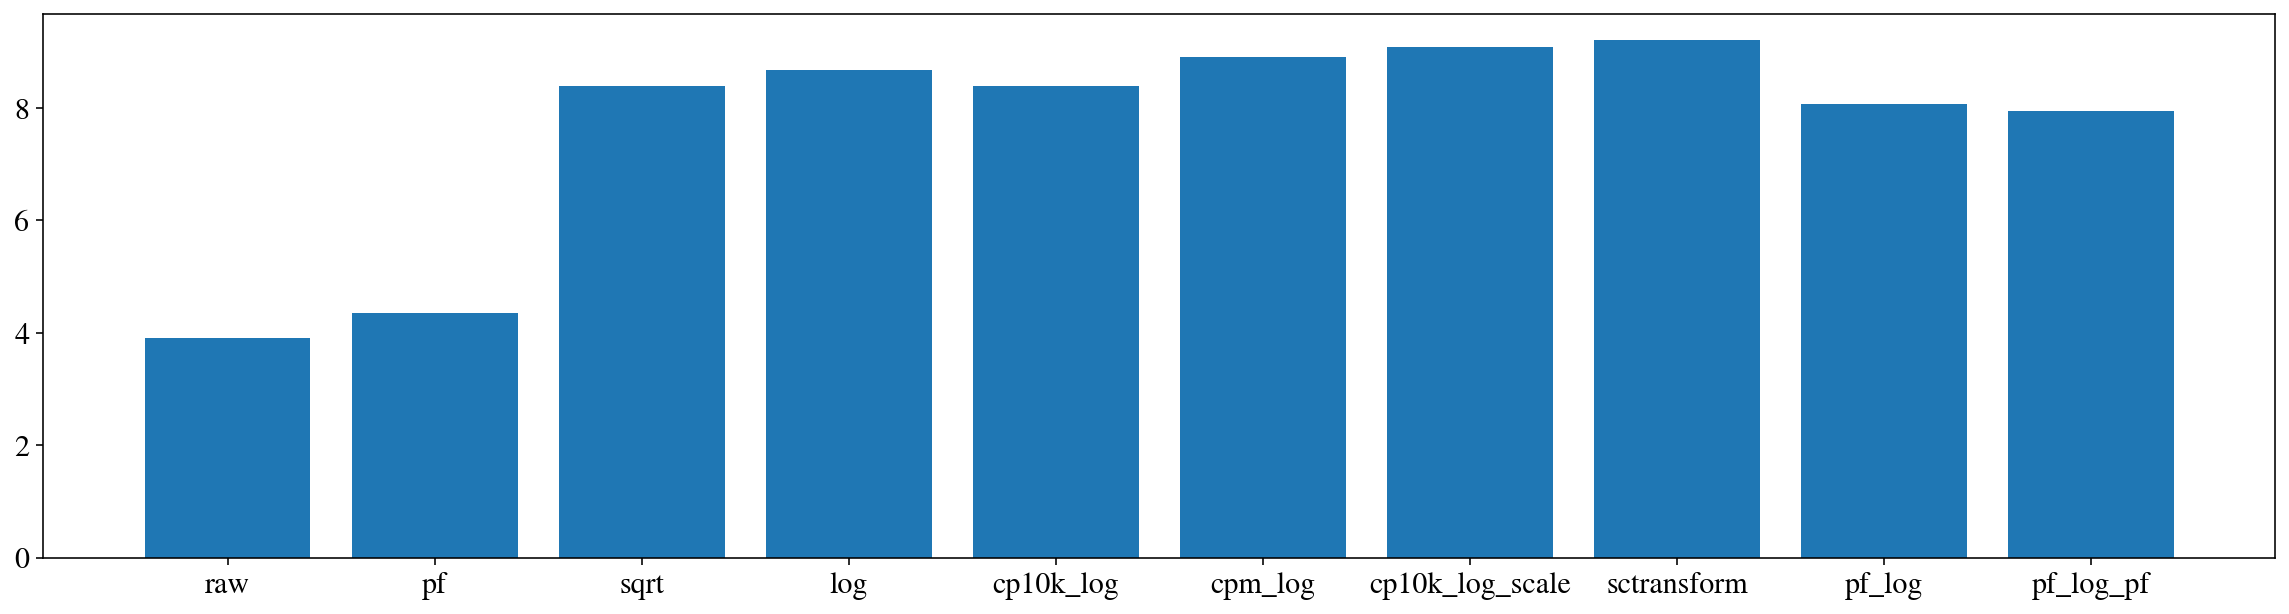

In [213]:
fig, ax = plt.subplots(figsize=(20,5))
x = labels
y = cmp[:,0]
ax.bar(x,y)
fig.show()

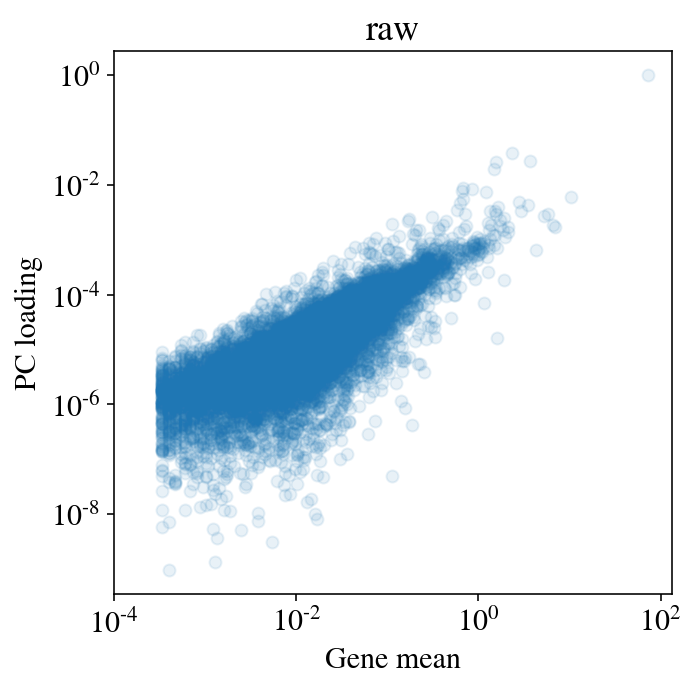

In [214]:
fig, ax = plt.subplots(figsize=(5,5))

x = np.mean(data["raw"], 0)
y = pcs["raw"][0]

ax.scatter(x,y, alpha=0.1)
ax.set(**{
    "xscale": "log",
    "yscale": "log",
    "xlim": (1e-4),
    "xlabel": "Gene mean",
    "ylabel": "PC loading",
    "title": "raw"
})
fig.show()

# Genes that flip

In [ ]:
# hunt for examples of two genes that switch order before and after transformation
# rank before, rank after, subtract and take abs value
# top 100 most expressed gene

In [186]:
raw = data["raw"][ctype_mask].mean(0)
ridx = np.argsort(raw)[-100:] # top 10 indices
raw = raw[ridx]
sct = data["sctransform"][ctype_mask].mean(0)[ridx]

In [196]:
(stats.rankdata(raw) - stats.rankdata(sct))

array([-30. , -45. , -53. , -85. , -53.5, -71.5, -18. , -20. ,  -7. ,
       -28. , -65. , -45. , -73. ,  -3. , -25. ,  -3. ,   8.5, -40.5,
       -13. ,  18.5,  14.5,  -7. , -37. , -12. ,  12.5, -17.5, -26. ,
       -20. , -21. ,   6. ,  24. , -43. , -54. , -35. , -49. , -37. ,
       -28. , -55. ,  17. , -24. ,  20. , -54. ,   9. ,  14. , -47. ,
       -34. ,  12. ,   9. , -32.5,   4.5,  37. , -38. ,   2. ,  -1. ,
       -26. , -12. ,  34. ,  48. ,  -3. ,  45. ,  50. ,  -4. ,  36. ,
       -10. ,   4. ,  33. ,  63. , -11. ,  23. ,   7. , -14. ,  35. ,
        55. ,  25. ,   8. ,  75. ,  25.5, -13.5, -19. ,  60. ,  37. ,
        41. ,   0. ,  12. ,  43. ,  -9. ,   9. ,  62. ,  -8. ,  -4. ,
        86. ,  80. ,  23. ,  -5. ,  92. ,   8. ,  43. ,  -2. ,  91. ,
        29. ])

In [202]:
stats.rankdata(raw)[94],  stats.rankdata(sct)[94]

(95.0, 3.0)

In [204]:
stats.rankdata(raw)[12],  stats.rankdata(sct)[12]

(13.0, 86.0)

In [198]:
np.argmax((stats.rankdata(raw) - stats.rankdata(sct)))

94

In [200]:
np.argmin((stats.rankdata(raw) - stats.rankdata(sct)))

3

In [205]:
genes[ridx][94], genes[ridx][12]

('Sftpc', 'Mpeg1')

In [199]:
raw[94], sct[94]

(9.49706572769953, -0.660092886629046)

In [251]:
raw[94],raw[12]

(9.49706572769953, 0.8321596244131455)

In [252]:
sct[94],sct[12]

(-0.660092886629046, 0.6946909081716823)

In [162]:
g1 = "Ace2"
gmask1 = g1 == genes

g2 = "Tmprss2"
gmask2 = g2 == genes

In [165]:
gmask1

array([False, False, False, ..., False, False, False])

In [177]:
c1 = data["raw"][:,gmask1] >= data["raw"][:,gmask2]

In [178]:
c2 = data["sctransform"][:,gmask1] >= data["sctransform"][:,gmask2]

In [182]:
(c1 != c2).sum()

0

In [180]:
c2

array([[False],
       [False],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

# DE on highest variable cluster

In [400]:
celltype = "Type_2_pneumocytes"
ctype_mask = assignments == celltype

In [401]:
cellsum = data["raw"][ctype_mask].sum(1)

In [402]:
np.argsort(cellsum)

array([3348, 1164, 2203, ..., 1300, 1984, 2043])

In [417]:
[1,2,3,4,5,6][-5:-3]

[2, 3]

In [425]:
n = 1000
min_sidx, max_sidx = np.array_split(np.argsort(cellsum), 2)

# ## for truncating
min_sidx = min_sidx[500:n]
max_sidx = max_sidx[-500:]
subset_idx = np.hstack([min_sidx, max_sidx])

# # # if truncating, use stack and sidx (on rows of matrix)
stack = np.hstack([np.zeros_like(min_sidx), np.ones_like(max_sidx)])
split_ct_assignments = stack

# # if not truncating then use this
# split_ct_assignments = np.hstack([stack[min_sidx], stack[max_sidx]])



In [426]:
#@title mx diff

from scipy.stats import ks_2samp, ttest_ind
import numpy as np
import pandas as pd
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')

import numpy as np
from statsmodels.stats.multitest import multipletests

def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """

    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def correct_pval(pval, nfeat, method):
    if method == 'bonferroni':
        pval_corr = np.minimum(pval*nfeat[:,None], 1.0)
    return pval_corr

def nd(arr):
    return np.asarray(arr).reshape(-1)
def correct_pvals(pvals):
    r = np.empty(np.shape(pvals))
    r[:] = np.nan
    for pidx, p in enumerate(pvals):
        mask = ~np.isnan(p)


    return r


def dexpress(mat, components, features, assignments, **kwargs):
    """
    mat: ndarray
    components: nparray
    features: nparray
    assignments: nparray, length is equal to length of components
    """
    nan_cutoff = kwargs.get("nan_cutoff", 0)
    
    unique = np.unique(assignments)
        
    ncomp = components.shape[0]
    nfeat = features.shape[0]
    nuniq = unique.shape[0]
    
    pval = np.empty((nuniq, nfeat)) # unique assignments by features 
    pval_corr = np.empty((nuniq, nfeat)) # unique assignments by features 
    stat = np.empty((nuniq, nfeat)) # unique assignments by features 
    es = np.empty((nuniq, nfeat)) # unique assignments by features 
    nfeatures = np.empty((nuniq))
    
    pval.fill(np.nan)
    pval_corr.fill(np.nan)
    stat.fill(np.nan)
    es.fill(np.nan)
    nfeatures.fill(np.nan)
    

    for tidx, t in enumerate(unique):
        logging.info("{} of {} assignments: {}".format(tidx+1, nuniq, t))

        t_mat, c_mat = split_by_target(mat, assignments, t, axis=0)
        
        pvalue = np.nan
        statistic = np.nan
        effect_size = np.nan

        # Keep only the genes for which it is in at least nan_cutoff*ncellsinclusters
        mask = np.asarray((t_mat>0).sum(axis=0) > nan_cutoff*t_mat.shape[0]).reshape(-1)

        t_mat = t_mat[:, mask]
        c_mat = c_mat[:, mask]
        # added

        # added
        if mask.sum()>0:
            test = ttest_ind(t_mat, c_mat, nan_policy="propagate", equal_var=False)
            pvalue = test.pvalue
            statistic = test.statistic
            effect_size = nd(t_mat.mean(axis=0)) - nd(c_mat.mean(axis=0))
            nfeatures[tidx] = mask.sum()

        pval[tidx,:][mask] = pvalue
        stat[tidx,:][mask] = statistic
        es[tidx,:][mask] = effect_size
    return (pval, stat, es, nfeatures)

def make_table(assignments, features, p_raw, p_corr, es):
    unique = np.unique(assignments)
    markers = pd.DataFrame(index=unique, columns=["name", "p_raw", "p_corr", "es"])

    for uidx, u in enumerate(unique):
        markers.loc[u]["name"] = features
        markers.loc[u]["p_raw"] = p_raw[uidx]
        markers.loc[u]["p_corr"] = p_corr[uidx]
        markers.loc[u]["es"] = es[uidx]

    markers = markers.apply(pd.Series.explode).reset_index()
    markers = markers[markers.notnull()["p_raw"]]
    markers = markers.rename(columns={"index": "group_id"})
    return markers

def diff(mat, components, features, assignments):

    unique = np.unique(assignments)
    nan_cutoff = 0.1 # of elements in cluster
    corr_method = "bonferroni"


    p_raw, stat, es, nfeat = dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
    p_raw = p_raw/2
    p_corr = correct_pval(p_raw, nfeat, corr_method)

    s = stat

    markers_gene = make_table(assignments, features, p_raw, p_corr, es)

    # convert the 0 pvalues to the smallest possible float
    markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
    # markers_gene = markers_gene.query("es > 0")
    return markers_gene

In [427]:
dfs = {}
for l in labels:
    dfs[l] = diff(data[l][ctype_mask][subset_idx], bcs[ctype_mask].index.values[subset_idx], genes, split_ct_assignments)

01-Mar-22 16:47:26 - 1 of 2 assignments: 0
01-Mar-22 16:47:26 - 2 of 2 assignments: 1
01-Mar-22 16:47:26 - /home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

01-Mar-22 16:47:27 - 1 of 2 assignments: 0
01-Mar-22 16:47:27 - 2 of 2 assignments: 1
01-Mar-22 16:47:27 - 1 of 2 assignments: 0
01-Mar-22 16:47:27 - 2 of 2 assignments: 1
01-Mar-22 16:47:28 - 1 of 2 assignments: 0
01-Mar-22 16:47:28 - 2 of 2 assignments: 1
01-Mar-22 16:47:28 - 1 of 2 assignments: 0
01-Mar-22 16:47:28 - 2 of 2 assignments: 1
01-Mar-22 16:47:28 - 1 of 2 assignments: 0
01-Mar-22 16:47:29 - 2 of 2 assignments: 1
01-Mar-22 16:47:29 - 1 of 2 assignments: 0
01-Mar-22 16:47:30 - 2 of 2 assignments: 1
01-Mar-22 16:47:30 - 1 of 2 assignments: 0
01-Mar-22 16:47:31 - 

In [428]:
res = {}
alpha = 0.01
for l in labels:
    df = dfs[l].query(f'p_corr < {alpha}')
    res[l] = df
    print(f"{df.name.nunique()}\t{l}")

2397	raw
16	pf
2412	sqrt
2410	log
1490	cp10k_log
2228	cpm_log
1490	cp10k_log_scale
435	sctransform
210	pf_log
22	pf_log_pf


In [429]:
# histogram for read depth with lines
# make upset plot